<a href="https://colab.research.google.com/github/siddhilandge/NNDL_2022/blob/main/Practical%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
df = pd.read_csv('/content/monthly_milk_production.csv',index_col='Date',parse_dates=True)   #Date is not  string
df.index.freq='MS'


In [6]:
df.head()     #month wise production data will be displayed


,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


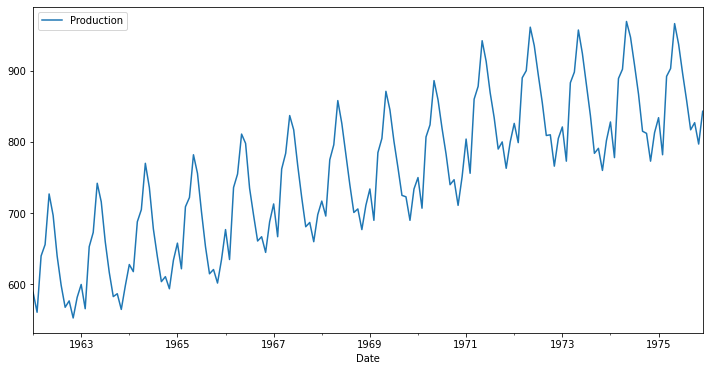

In [8]:
df.plot(figsize=(12,6))


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


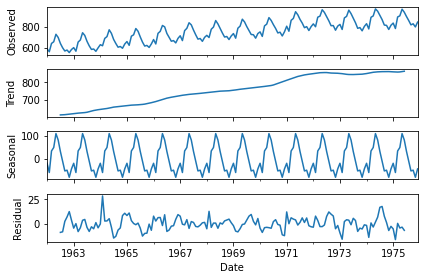

In [10]:
results = seasonal_decompose(df['Production'])
results.plot();


In [11]:
len(df)


168

In [12]:
train = df.iloc[:156]        # all data except the last 12 months data 168-12=156
test = df.iloc[156:]         # Last 12 months data


In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [14]:
df.head(),df.tail()       #magnitude of the production values not in proper range


(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [16]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)


In [17]:
scaled_train[:10]    # transform method covert the values in the 0...1.


array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator


In [20]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)


In [21]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')


Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [22]:
X.shape        # 1 row 3 columns and 1 feature


(1, 3, 1)

In [23]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)


In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [25]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [26]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [28]:
# fit model
model.fit(generator,epochs=50)  #generator creates batches of 3-3 inputs and using that predict the next value


Epoch 1/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0270
Epoch 2/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0232
Epoch 3/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0142
Epoch 4/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0114
Epoch 5/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0064
Epoch 6/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0038
Epoch 7/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0056
Epoch 8/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0032
Epoch 9/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0031
Epoch 10/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0039
Epoch 11/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0032
Epoch 12/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0038
Epoch 13/50
144/144 [====

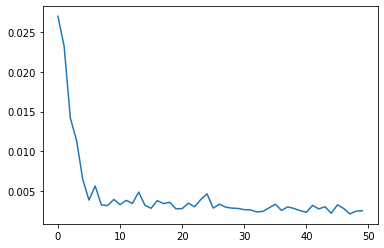

In [29]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)


In [30]:
last_train_batch = scaled_train[-12:] #taking last 12 months values in training set to make prediction for 1st value in test set


In [31]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))


In [32]:
model.predict(last_train_batch)


array([[0.5774372]], dtype=float32)

In [33]:
scaled_test[0]      # original value was 0.67 model predicted it to be 0.65


array([0.67548077])

In [34]:
test_predictions = []     #empty list of test predictions

first_eval_batch = scaled_train[-n_input:]      #last 12 values from the training set
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


In [35]:
test_predictions


[array([0.5774372], dtype=float32),
 array([0.568895], dtype=float32),
 array([0.7195525], dtype=float32),
 array([0.7886305], dtype=float32),
 array([0.85679215], dtype=float32),
 array([0.8519984], dtype=float32),
 array([0.8011683], dtype=float32),
 array([0.7181455], dtype=float32),
 array([0.6207514], dtype=float32),
 array([0.57599217], dtype=float32),
 array([0.5294448], dtype=float32),
 array([0.5538796], dtype=float32)]

In [36]:
test.head()


,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [37]:
true_predictions = scaler.inverse_transform(test_predictions)


In [38]:
test['Predictions'] = true_predictions


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


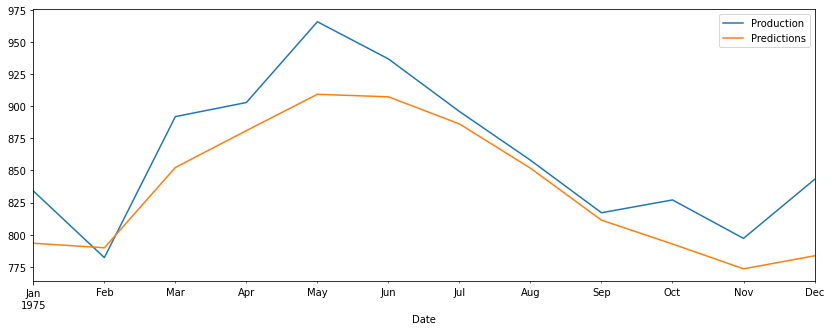

In [39]:
test.plot(figsize=(14,5))


In [40]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)


33.310756505829076
